In [18]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import pickle
import random
import importlib
import sys

import shap
from pdpbox import pdp
import matplotlib.pyplot as plt
import japanize_matplotlib

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Attention, Multiply, Lambda, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam, RMSprop, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

In [19]:
import common

# モジュールの再読み込み
importlib.reload(common)

_common = common.Common()
_common.BASE_PATH

PosixPath('/Users/iwasakitakahiro/github')

In [20]:
common_func_path = _common.COMMON_FUNC_PATH
sys.path.append(str(common_func_path))

import func

importlib.reload(func)

<module 'func' from '/Users/iwasakitakahiro/github/共通関数/func.py'>

In [21]:
train_df = pd.read_csv('../output/中間データ/学習用データ/train_preprocessed.csv')
test_df = pd.read_csv('../output/中間データ/評価用データ/test_preprocessed.csv')

In [22]:
# 再現性確保のための固定シード
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

# Optunaのシードも固定
sampler = optuna.samplers.TPESampler(seed=SEED)

In [23]:
# 前処理
exclude_cols = ['time', 'price_actual']  # 目的変数＋timeは除外
features = [col for col in train_df.columns if col not in exclude_cols]
target_col = 'price_actual'

bin_cols = ['is_holiday', 'tight_supply_flag']
cont_cols = [c for c in features if c not in bin_cols]

scaler = MinMaxScaler().fit(train_df[cont_cols])
train_scaled = scaler.transform(train_df[cont_cols])
test_scaled  = scaler.transform(test_df[cont_cols])

# 動的入力：連続 + バイナリそのまま
train_features = np.hstack([train_scaled, train_df[bin_cols].values])
test_features  = np.hstack([test_scaled,  test_df[bin_cols].values])

## SEQ_LEN: 24時間前

In [24]:
# --- LSTM用の時系列ウィンドウデータ作成 ---
SEQ_LEN = 24
X, y = [], []
for i in range(len(train_features) - SEQ_LEN):
    X.append(train_features[i:i+SEQ_LEN])
    y.append(train_df[target_col].iloc[i+SEQ_LEN])
X = np.array(X)
y = np.array(np.log1p(y))

# trainの最後SEQ_LEN行を取得
tail_train = train_features[-SEQ_LEN:, :]   # shape: (SEQ_LEN, 特徴量数)

# test_features（np.array）と連結
concat_test = np.vstack([tail_train, test_features])   # shape: (SEQ_LEN + len(test), 特徴量数)
concat_test_df = pd.DataFrame(concat_test, columns=features)
concat_test_df.to_csv('../output/中間データ/評価用データ/test_features_for_lstm24.csv', index=False)

#### ハイパーパラメータチューニング

In [25]:
def create_lstm_attention_model(input_shape, units, num_layers, dropout, lr, l2_lambda, dense_units=32):
    inputs = Input(shape=input_shape)

    x = inputs
    for i in range(num_layers):
        x = LSTM(units, return_sequences=True, dropout=dropout,
                 kernel_regularizer=l2(l2_lambda))(x)

    # Attention (Self-Attention)
    attention_output = Attention()([x, x])  # shape: [batch, time, units]
    context_vector = GlobalAveragePooling1D()(attention_output)  # shape: [batch, units]

    x = Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_lambda))(context_vector)
    output = Dense(1, activation='linear', kernel_regularizer=l2(l2_lambda))(x)

    model = Model(inputs=inputs, outputs=output)
    # model.compile(optimizer=RMSprop(learning_rate=lr), loss='mse')
    model.compile(optimizer=AdamW(1e-3), loss=tf.keras.losses.Huber(delta=20))
    return model

def objective(trial):
    units = trial.suggest_categorical('units', [32, 64, 128])
    num_layers = trial.suggest_int('num_layers', 1, 2)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    learning_rate = trial.suggest_float('lr', 1e-4, 1e-2)
    l2_lambda = trial.suggest_float('l2', 1e-7, 1e-3, log=True)

    tscv = TimeSeriesSplit(n_splits=3)
    rmses = []
    for train_idx, val_idx in tscv.split(X):  # あなたのX, yのウィンドウ化後配列を前提
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = create_lstm_attention_model((X.shape[1], X.shape[2]), units, num_layers, dropout, learning_rate, l2_lambda)
        es = EarlyStopping(patience=20, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6)

        model.fit(
            X_train, y_train,
            epochs=200,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            verbose=0,
            callbacks=[es, reduce_lr]
        )

        y_pred = model.predict(X_val).flatten()
        rmse = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(y_pred)))
        rmses.append(rmse)

    return np.mean(rmses)

# --- Optunaでパラメータ探索 ---
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)

print("Best params:", study.best_params)
print("Best CV RMSE:", study.best_value)

[I 2025-06-18 07:20:47,507] A new study created in memory with name: no-name-b3d8e4e0-5632-49f6-aca1-fcfe971aab66


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step


[I 2025-06-18 07:23:39,947] Trial 0 finished with value: 13.280151757703223 and parameters: {'units': 32, 'num_layers': 1, 'dropout': 0.2875027280294855, 'batch_size': 32, 'lr': 0.0012024271332481814, 'l2': 1.9100117696145977e-07}. Best is trial 0 with value: 13.280151757703223.


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-06-18 07:27:15,159] Trial 1 finished with value: 12.396381488124524 and parameters: {'units': 32, 'num_layers': 1, 'dropout': 0.19248363724104595, 'batch_size': 16, 'lr': 0.0064521514794948385, 'l2': 1.6682473114624767e-07}. Best is trial 1 with value: 12.396381488124524.


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-06-18 07:31:05,925] Trial 2 finished with value: 12.983086918593655 and parameters: {'units': 128, 'num_layers': 1, 'dropout': 0.2982870714821235, 'batch_size': 64, 'lr': 0.009972226141402994, 'l2': 7.766054870958582e-07}. Best is trial 1 with value: 12.396381488124524.


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-06-18 07:36:28,754] Trial 3 finished with value: 13.026582675602441 and parameters: {'units': 64, 'num_layers': 2, 'dropout': 0.26765351006578, 'batch_size': 32, 'lr': 0.004695302098577037, 'l2': 1.414395685390351e-06}. Best is trial 1 with value: 12.396381488124524.


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-06-18 07:45:07,127] Trial 4 finished with value: 12.914668821098802 and parameters: {'units': 64, 'num_layers': 2, 'dropout': 0.11173427819331212, 'batch_size': 32, 'lr': 0.009937356452926236, 'l2': 0.0005285072720874012}. Best is trial 1 with value: 12.396381488124524.


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[I 2025-06-18 08:01:57,002] Trial 5 finished with value: 12.031897122249399 and parameters: {'units': 128, 'num_layers': 2, 'dropout': 0.2086256460377257, 'batch_size': 32, 'lr': 0.009489187343057233, 'l2': 3.7707799079880474e-05}. Best is trial 5 with value: 12.031897122249399.


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-06-18 08:08:02,823] Trial 6 finished with value: 12.37325029550665 and parameters: {'units': 64, 'num_layers': 2, 'dropout': 0.27651881190432415, 'batch_size': 32, 'lr': 0.0039514633239483435, 'l2': 6.80119538842334e-07}. Best is trial 5 with value: 12.031897122249399.


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-06-18 08:18:38,542] Trial 7 finished with value: 12.547614074943867 and parameters: {'units': 64, 'num_layers': 2, 'dropout': 0.3667324760435, 'batch_size': 16, 'lr': 0.002857818153984576, 'l2': 1.8516493005812156e-07}. Best is trial 5 with value: 12.031897122249399.


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


[I 2025-06-18 08:54:31,502] Trial 8 finished with value: 12.560069038817744 and parameters: {'units': 128, 'num_layers': 2, 'dropout': 0.18884616740192134, 'batch_size': 16, 'lr': 0.007334576822081806, 'l2': 9.285626135535096e-06}. Best is trial 5 with value: 12.031897122249399.


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-06-18 09:04:48,410] Trial 9 finished with value: 12.606962605051939 and parameters: {'units': 64, 'num_layers': 2, 'dropout': 0.10910172620327861, 'batch_size': 16, 'lr': 0.00738322549765662, 'l2': 2.6237546508053486e-06}. Best is trial 5 with value: 12.031897122249399.


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-06-18 09:11:09,902] Trial 10 finished with value: 13.046118798464853 and parameters: {'units': 128, 'num_layers': 1, 'dropout': 0.48473458796378127, 'batch_size': 64, 'lr': 0.00840735362020614, 'l2': 0.0001522702756690579}. Best is trial 5 with value: 12.031897122249399.


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


[I 2025-06-18 09:42:20,867] Trial 11 finished with value: 13.111193165834287 and parameters: {'units': 128, 'num_layers': 2, 'dropout': 0.3849315992685508, 'batch_size': 32, 'lr': 0.00406982633141637, 'l2': 4.4137632175197384e-05}. Best is trial 5 with value: 12.031897122249399.


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


[I 2025-06-18 10:16:37,084] Trial 12 finished with value: 12.04536131703864 and parameters: {'units': 128, 'num_layers': 2, 'dropout': 0.2030767341637743, 'batch_size': 32, 'lr': 0.0024260731774238533, 'l2': 1.812008949141705e-05}. Best is trial 5 with value: 12.031897122249399.


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


[I 2025-06-18 14:11:27,014] Trial 13 finished with value: 12.166126274755038 and parameters: {'units': 128, 'num_layers': 2, 'dropout': 0.198597293853071, 'batch_size': 32, 'lr': 0.000939595995517766, 'l2': 2.466240081718981e-05}. Best is trial 5 with value: 12.031897122249399.


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


[I 2025-06-18 14:49:17,079] Trial 14 finished with value: 12.274137892750906 and parameters: {'units': 128, 'num_layers': 2, 'dropout': 0.22260556239955612, 'batch_size': 32, 'lr': 0.0023771238168786226, 'l2': 7.052336041359656e-06}. Best is trial 5 with value: 12.031897122249399.


Best params: {'units': 128, 'num_layers': 2, 'dropout': 0.2086256460377257, 'batch_size': 32, 'lr': 0.009489187343057233, 'l2': 3.7707799079880474e-05}
Best CV RMSE: 12.031897122249399


#### 全データで学習

In [26]:
best_params = study.best_params
units = best_params['units']
num_layers = best_params['num_layers']
dropout = best_params['dropout']
batch_size = best_params['batch_size']
learning_rate = best_params['lr']
l2_lambda = best_params['l2']

Epoch 1/100
821/821 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.2639 - learning_rate: 0.0010
Epoch 2/100
821/821 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.0410 - learning_rate: 0.0010
Epoch 3/100
821/821 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.0371 - learning_rate: 0.0010
Epoch 4/100
821/821 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.0336 - learning_rate: 0.0010
Epoch 5/100
821/821 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - loss: 0.0313 - learning_rate: 0.0010
Epoch 6/100
821/821 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.0291 - learning_rate: 0.0010
Epoch 7/100
821/821 ━━━━━━━━━━━━━━━━━━━━ 1007s 1s/step - loss: 0.0275 - learning_rate: 0.0010
Epoch 8/100
821/821 ━━━━━━━━━━━━━━━━━━━━ 4028s 5s/step - loss: 0.0253 - learning_rate: 0.0010
Epoch 9/100
821/821 ━━━━━━━━━━━━━━━━━━━━ 1932s 2s/step - loss: 0.0251 - learning_rate: 0.0010
Epoch 10/100
821/821 ━━━━━━━━━━━━━━━━━━━━ 1897s 2s/step - loss: 0.0265 - learning_rate: 0.0010
Epoch 11/100
821/821 ━━━━━━━━━━━━━━━━━━━━ 1154s 1s/step - l

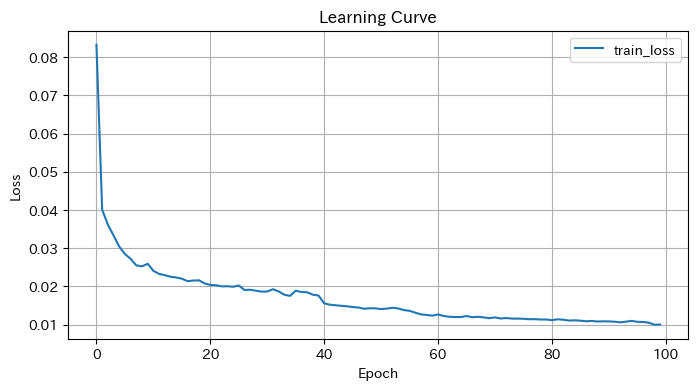

In [27]:
X_all, y_all = [], []
for i in range(len(train_features) - SEQ_LEN):
    X_all.append(train_features[i:i+SEQ_LEN])
    y_all.append(train_df[target_col].iloc[i+SEQ_LEN])
X_all = np.array(X_all)
y_all = np.array(np.log1p(y_all))

# --- Attention付きLSTMモデルの構築 ---
model = create_lstm_attention_model(
    input_shape=(SEQ_LEN, X_all.shape[2]),
    units=units,
    num_layers=num_layers,
    dropout=dropout,
    lr=learning_rate,
    l2_lambda=l2_lambda
)

# --- コールバックの設定 ---
es = EarlyStopping(patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# --- 学習 ---
history = model.fit(
    X_all, y_all,
    epochs=100,
    batch_size=batch_size,
    verbose=1,
    callbacks=[es, reduce_lr]
)

# --- 全データでの予測とRMSE計算 ---
y_pred = model.predict(X_all).flatten()
rmse = np.sqrt(mean_squared_error(np.expm1(y_all), np.expm1(y_pred)))
print(f"Train RMSE: {rmse:.3f}")

# --- 学習曲線の可視化 ---
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
model.save('../output/モデル/lstm_model24.keras')

## SEQ_LEN: 1週間

In [ ]:
# --- LSTM用の時系列ウィンドウデータ作成 ---
SEQ_LEN = 168
X, y = [], []
for i in range(len(train_features) - SEQ_LEN):
    X.append(train_features[i:i+SEQ_LEN])
    y.append(train_df[target_col].iloc[i+SEQ_LEN])
X = np.array(X)
y = np.array(np.log1p(y))

# trainの最後SEQ_LEN行を取得
tail_train = train_features[-SEQ_LEN:, :]   # shape: (SEQ_LEN, 特徴量数)

# test_features（np.array）と連結
concat_test = np.vstack([tail_train, test_features])   # shape: (SEQ_LEN + len(test), 特徴量数)
concat_test_df = pd.DataFrame(concat_test, columns=features)
concat_test_df.to_csv('../output/中間データ/評価用データ/test_features_for_lstm168.csv', index=False)

#### ハイパーパラメータチューニング

In [ ]:
def create_lstm_attention_model(input_shape, units, num_layers, dropout, lr, l2_lambda, dense_units=32):
    inputs = Input(shape=input_shape)

    x = inputs
    for i in range(num_layers):
        x = LSTM(units, return_sequences=True, dropout=dropout,
                 kernel_regularizer=l2(l2_lambda))(x)

    # Attention (Self-Attention)
    attention_output = Attention()([x, x])  # shape: [batch, time, units]
    context_vector = GlobalAveragePooling1D()(attention_output)  # shape: [batch, units]

    x = Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_lambda))(context_vector)
    output = Dense(1, activation='linear', kernel_regularizer=l2(l2_lambda))(x)

    model = Model(inputs=inputs, outputs=output)
    # model.compile(optimizer=RMSprop(learning_rate=lr), loss='mse')
    model.compile(optimizer=AdamW(1e-3), loss=tf.keras.losses.Huber(delta=20))
    return model

def objective(trial):
    units = trial.suggest_categorical('units', [32, 64, 128])
    num_layers = trial.suggest_int('num_layers', 1, 2)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    learning_rate = trial.suggest_float('lr', 1e-4, 1e-2)
    l2_lambda = trial.suggest_float('l2', 1e-7, 1e-3, log=True)

    tscv = TimeSeriesSplit(n_splits=3)
    rmses = []
    for train_idx, val_idx in tscv.split(X):  # あなたのX, yのウィンドウ化後配列を前提
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = create_lstm_attention_model((X.shape[1], X.shape[2]), units, num_layers, dropout, learning_rate, l2_lambda)
        es = EarlyStopping(patience=20, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6)

        model.fit(
            X_train, y_train,
            epochs=200,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            verbose=0,
            callbacks=[es, reduce_lr]
        )

        y_pred = model.predict(X_val).flatten()
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmses.append(rmse)

    return np.mean(rmses)

# --- Optunaでパラメータ探索 ---
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)

print("Best params:", study.best_params)
print("Best CV RMSE:", study.best_value)

[I 2025-06-11 10:11:10,001] A new study created in memory with name: no-name-f9f4c257-27c4-45b6-86a9-e8ce5f770edf
[W 2025-06-11 10:11:40,634] Trial 0 failed with parameters: {'units': 64, 'num_layers': 2, 'dropout': 0.2985807913397629, 'batch_size': 32, 'lr': 0.008091627020217134, 'l2': 6.51118212219688e-07} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/sb/t91v_nzj05sbsfnhcjb832xr0000gn/T/ipykernel_5924/1792540141.py", line 38, in objective
    model.fit(
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3

KeyboardInterrupt: 

#### 全データで学習

In [ ]:
best_params = study.best_params
units = best_params['units']
num_layers = best_params['num_layers']
dropout = best_params['dropout']
batch_size = best_params['batch_size']
learning_rate = best_params['lr']
l2_lambda = best_params['l2']

In [ ]:
X_all, y_all = [], []
for i in range(len(train_features) - SEQ_LEN):
    X_all.append(train_features[i:i+SEQ_LEN])
    y_all.append(train_df[target_col].iloc[i+SEQ_LEN])
X_all = np.array(X_all)
y_all = np.array(y_all)

# --- Attention付きLSTMモデルの構築 ---
model = create_lstm_attention_model(
    input_shape=(SEQ_LEN, X_all.shape[2]),
    units=units,
    num_layers=num_layers,
    dropout=dropout,
    lr=learning_rate,
    l2_lambda=l2_lambda
)

# --- コールバックの設定 ---
es = EarlyStopping(patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# --- 学習 ---
history = model.fit(
    X_all, y_all,
    epochs=100,
    batch_size=batch_size,
    verbose=1,
    callbacks=[es, reduce_lr]
)

# --- 全データでの予測とRMSE計算 ---
y_pred = model.predict(X_all).flatten()
rmse = np.sqrt(mean_squared_error(y_all, y_pred))
print(f"Train RMSE: {rmse:.3f}")

# --- 学習曲線の可視化 ---
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - loss: 1726.6941
Epoch 2/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - loss: 249.2115
Epoch 3/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - loss: 198.7570
Epoch 4/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - loss: 124.8483
Epoch 5/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - loss: 105.8403
Epoch 6/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - loss: 95.3063
Epoch 7/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - loss: 88.0377
Epoch 8/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - loss: 85.3183
Epoch 9/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - loss: 84.7468
Epoch 10/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - loss: 80.5158
Epoch 11/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - loss: 76.4179
Epoch 12/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 1032s 3s/step - loss: 71.8479
Epoch 13/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - loss: 73.5621
Epoch 14/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - loss: 72.4995
Epoch 15/

In [ ]:
model.save('../output/モデル/lstm_model168.keras')

## SEQ_LEN: 1ヶ月

In [ ]:
# --- LSTM用の時系列ウィンドウデータ作成 ---
SEQ_LEN = 720
X, y = [], []
for i in range(len(train_features) - SEQ_LEN):
    X.append(train_features[i:i+SEQ_LEN])
    y.append(train_df[target_col].iloc[i+SEQ_LEN])
X = np.array(X)
y = np.array(np.log1p(y))

# trainの最後SEQ_LEN行を取得
tail_train = train_features[-SEQ_LEN:, :]   # shape: (SEQ_LEN, 特徴量数)

# test_features（np.array）と連結
concat_test = np.vstack([tail_train, test_features])   # shape: (SEQ_LEN + len(test), 特徴量数)
concat_test_df = pd.DataFrame(concat_test, columns=features)
concat_test_df.to_csv('../output/中間データ/評価用データ/test_features_for_lstm720.csv', index=False)

#### ハイパーパラメータチューニング

In [ ]:
def create_lstm_attention_model(input_shape, units, num_layers, dropout, lr, l2_lambda, dense_units=32):
    inputs = Input(shape=input_shape)

    x = inputs
    for i in range(num_layers):
        x = LSTM(units, return_sequences=True, dropout=dropout,
                 kernel_regularizer=l2(l2_lambda))(x)

    # Attention (Self-Attention)
    attention_output = Attention()([x, x])  # shape: [batch, time, units]
    context_vector = GlobalAveragePooling1D()(attention_output)  # shape: [batch, units]

    x = Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_lambda))(context_vector)
    output = Dense(1, activation='linear', kernel_regularizer=l2(l2_lambda))(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=RMSprop(learning_rate=lr), loss='mse')
    return model

def objective(trial):
    units = trial.suggest_categorical('units', [32, 64, 128])
    num_layers = trial.suggest_int('num_layers', 1, 2)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    learning_rate = trial.suggest_float('lr', 1e-4, 1e-2)
    l2_lambda = trial.suggest_float('l2', 1e-7, 1e-3, log=True)

    tscv = TimeSeriesSplit(n_splits=3)
    rmses = []
    for train_idx, val_idx in tscv.split(X):  # あなたのX, yのウィンドウ化後配列を前提
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = create_lstm_attention_model((X.shape[1], X.shape[2]), units, num_layers, dropout, learning_rate, l2_lambda)
        es = EarlyStopping(patience=20, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6)

        model.fit(
            X_train, y_train,
            epochs=200,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            verbose=0,
            callbacks=[es, reduce_lr]
        )

        y_pred = model.predict(X_val).flatten()
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmses.append(rmse)

    return np.mean(rmses)

# --- Optunaでパラメータ探索 ---
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)

print("Best params:", study.best_params)
print("Best CV RMSE:", study.best_value)

[I 2025-06-09 07:29:29,594] A new study created in memory with name: no-name-97ac65c7-8ceb-4beb-b1e1-63043373cde5


200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step


[I 2025-06-09 07:44:49,040] Trial 0 finished with value: 13.685517930485718 and parameters: {'units': 32, 'num_layers': 1, 'dropout': 0.3835501303239237, 'batch_size': 64, 'lr': 0.009183389122550368}. Best is trial 0 with value: 13.685517930485718.


200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step


[W 2025-06-09 09:22:07,411] Trial 1 failed with parameters: {'units': 32, 'num_layers': 2, 'dropout': 0.46850881206753436, 'batch_size': 64, 'lr': 0.0014355950712513347} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/sb/t91v_nzj05sbsfnhcjb832xr0000gn/T/ipykernel_80921/272806354.py", line 29, in objective
    model.fit(
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit
    logs = self.train_function(iterator)
       

KeyboardInterrupt: 

#### 全データで学習

In [ ]:
best_params = study.best_params
units = best_params['units']
num_layers = best_params['num_layers']
dropout = best_params['dropout']
batch_size = best_params['batch_size']
learning_rate = best_params['lr']
l2_lambda = best_params['l2']

In [ ]:
X_all, y_all = [], []
for i in range(len(train_features) - SEQ_LEN):
    X_all.append(train_features[i:i+SEQ_LEN])
    y_all.append(train_df[target_col].iloc[i+SEQ_LEN])
X_all = np.array(X_all)
y_all = np.array(y_all)

# --- Attention付きLSTMモデルの構築 ---
model = create_lstm_attention_model(
    input_shape=(SEQ_LEN, X_all.shape[2]),
    units=units,
    num_layers=num_layers,
    dropout=dropout,
    lr=learning_rate,
    l2_lambda=l2_lambda
)

# --- コールバックの設定 ---
es = EarlyStopping(patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# --- 学習 ---
history = model.fit(
    X_all, y_all,
    epochs=100,
    batch_size=batch_size,
    verbose=1,
    callbacks=[es, reduce_lr]
)

# --- 全データでの予測とRMSE計算 ---
y_pred = model.predict(X_all).flatten()
rmse = np.sqrt(mean_squared_error(y_all, y_pred))
print(f"Train RMSE: {rmse:.3f}")

# --- 学習曲線の可視化 ---
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.save('../output/モデル/lstm_model720.keras')